# **Ouroboros EEG-fMRI: Predicting EEG activity from fMRI activity and vice versa**

#### Version: 22nd August 2022

==============================================================================================

Project developed by Maël Donoso, Ph.D. in Cognitive and Computational Neuroscience. Affiliations: Ouroboros Neurotechnologies (https://ouroboros-neurotechnologies.com/), Institut Lémanique du Cerveau (https://institut-cerveau.ch/), Policlinique Ostéopathique de Lausanne (https://policlinique-osteopathique-lausanne.ch/). 

==============================================================================================

This project is presented through five Notebooks:

*01: Data Analysis*

*02: Classification*

*03: Regression on fMRI data*

*04: Regression on EEG data*

***05: Results***

==============================================================================================

### Notebook 05

# **Results**

## **1. Introduction to Results**

### 1.1 Overview

In this project, we worked with data obtained by **Electroencephalography (EEG)** and **functional Magnetic Resonance Imaging (fMRI)**, two of the major tools used by neuroscientists for brain activity investigation. In the first Notebook on Data Analysis, we pointed out the fact that these two techniques allow the investigation of neural activity at two different levels: while EEG measures the electrical activity of the brain, using electrodes placed on the head, fMRI on the other hand measures the activity of the brain indirectly, by detecting the changes in the cerebral blood flow. The dataset that we have chosen contains also a third data type, the **hypnogram**, which records the evolution of sleep stages during a rest period. 

After using several classification and regression models, we are now ready to answer the question: **can we train machine learning models to predict EEG activity from fMRI activity, and vice versa?**

### 1.2 Data import

In the following cells, we **define the results path** and the list of subjects. 

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Define the results path. If empty, the results will be loaded from the current directory. 
results_path = ''

In [3]:
# Define the list of subjects. 
subjects = []

for subject_index in range(18):
    if subject_index < 9:
        subjects.append('sub-0' + str(subject_index + 1))
    else:
        subjects.append('sub-' + str(subject_index + 1))

print(subjects)

['sub-01', 'sub-02', 'sub-03', 'sub-04', 'sub-05', 'sub-06', 'sub-07', 'sub-08', 'sub-09', 'sub-10', 'sub-11', 'sub-12', 'sub-13', 'sub-14', 'sub-15', 'sub-16', 'sub-17', 'sub-18']


In [4]:
# Define a function to return the middle sections of an image data array. 
def middle_sections(image_data):
    return tuple((np.array(image_data[:, :, :].shape) / 2).astype(int))

In [5]:
# Define a function to display the position of a voxel or cluster, with one image as background. 
def display_voxel_or_cluster_position(voxel_index, background_image, image_data_shape):
    fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (12, 4))

    # Sagittal view. 
    axes[0].imshow(background_image[voxel_index[0], :, :].T, origin = 'lower')
    axes[0].axhline(voxel_index[2], 0, image_data_shape[1], color = 'yellow') # Horizontal line through coronal view. 
    axes[0].axvline(voxel_index[1], 0, image_data_shape[2], color = 'yellow') # Vertical line through axial view. 
    axes[0].scatter(voxel_index[1], voxel_index[2], marker = 'o', c = 'white')
    axes[0].set_title('Sagittal view')

    # Coronal view. 
    axes[1].imshow(background_image[:, voxel_index[1], :].T, origin = 'lower')
    axes[1].axhline(voxel_index[2], 0, image_data_shape[0], color = 'yellow') # Horizontal line through sagittal view. 
    axes[1].axvline(voxel_index[0], 0, image_data_shape[2], color = 'yellow') # Vertical line through axial view. 
    axes[1].scatter(voxel_index[0], voxel_index[2], marker = 'o', c = 'white')
    axes[1].set_title('Coronal view')

    # Axial view. 
    axes[2].imshow(background_image[:, :, voxel_index[2]], origin = 'lower')
    axes[2].axhline(voxel_index[0], 0, image_data_shape[1], color = 'yellow') # Horizontal line through coronal view. 
    axes[2].axvline(voxel_index[1], 0, image_data_shape[0], color = 'yellow') # Vertical line through sagittal view. 
    axes[2].scatter(voxel_index[1], voxel_index[0], marker = 'o', c = 'white')
    axes[2].set_title('Axial view')
    plt.show();

## **2. Classification results**

In the following cells, we load the results from the **Notebook on Classification**, and display the accuracy of the different classification models. We start with the models using the EEG data as predictors, and continue with the models using the fMRI data as predictors. In the Notebook on Classification, a train/test split was done for each model, and as a consequence, each model has its own baseline. 

In [6]:
# Load the results from the classification based on EEG data. 
with np.load(results_path + 'classification_with_EEG_predictors.npz', allow_pickle = False) as npz_file:
    data_dict = dict(npz_file.items())

# Store the results as DataFrames. 
knn_results = pd.DataFrame(data_dict['knn_results'], index = subjects, columns = ['knn__n_neighbors', 'test_score', 'baseline'])
dt_results = pd.DataFrame(data_dict['dt_results'], index = subjects, columns = ['dt__max_depth', 'test_score', 'baseline'])
rf_results = pd.DataFrame(data_dict['rf_results'], index = subjects, columns = ['rf__n_estimators', 'test_score', 'baseline'])
svm_results = pd.DataFrame(data_dict['svm_results'], index = subjects, columns = ['svm__C', 'test_score', 'baseline'])
logreg_results = pd.DataFrame(data_dict['logreg_results'], index = subjects, columns = ['logreg__C', 'test_score', 'baseline'])

In [7]:
# Create a Pandas DataFrame to hold all the test scores. 
classification_based_on_EEG = pd.DataFrame()
for classification_model in ['knn', 'dt', 'rf', 'svm', 'logreg']:
    classification_based_on_EEG[classification_model] = eval(classification_model + '_results')['test_score']

# Display the DataFrame. 
classification_based_on_EEG

,knn,dt,rf,svm,logreg
sub-01,0.939815,0.810185,0.873457,0.766975,0.751543
sub-02,0.980360,0.890344,0.941080,0.885434,0.878887
sub-03,0.923077,0.775000,0.834615,0.711538,0.728846
sub-04,0.927660,0.776596,0.848936,0.751064,0.727660
sub-05,0.931755,0.853760,0.917827,0.850975,0.824513
sub-06,0.915563,0.832781,0.869205,0.794702,0.809603
sub-07,0.935484,0.810247,0.891841,0.774194,0.787476
sub-08,0.910494,0.790123,0.907407,0.753086,0.790123
sub-09,0.932790,0.841141,0.898167,0.816701,0.814664
sub-10,0.934358,0.833799,0.877095,0.824022,0.789106


In [8]:
# Create a Pandas DataFrame to hold all the baselines. 
classification_based_on_EEG_baselines = pd.DataFrame()
for classification_model in ['knn', 'dt', 'rf', 'svm', 'logreg']:
    classification_based_on_EEG_baselines[classification_model] = eval(classification_model + '_results')['baseline']

In [9]:
# Display the mean test score for the classification models. 
classification_based_on_EEG.mean()

knn       0.925655
dt        0.812183
rf        0.877575
svm       0.763108
logreg    0.764349
dtype: float64

In [10]:
# Display the mean baseline for the classification models. 
classification_based_on_EEG_baselines.mean()

knn       0.511861
dt        0.517655
rf        0.507974
svm       0.511406
logreg    0.513957
dtype: float64

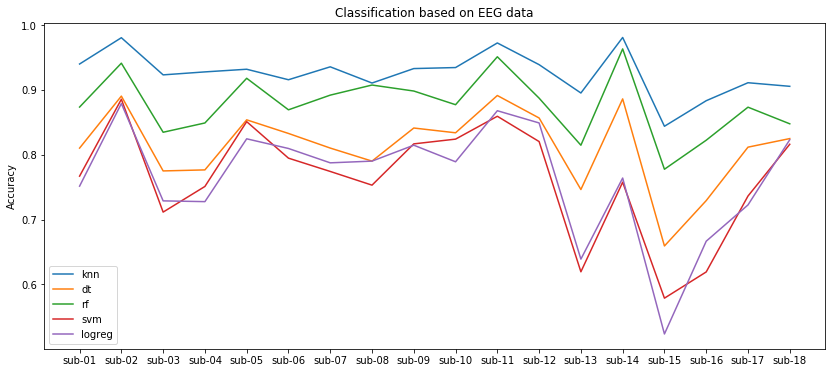

In [11]:
# Display the test score for all subjects and all models. 
plt.figure(figsize = ((14, 6)))
for classification_model in ['knn', 'dt', 'rf', 'svm', 'logreg']:
    plt.plot(classification_based_on_EEG[classification_model], label = classification_model)
plt.legend()
plt.ylabel('Accuracy')
plt.title('Classification based on EEG data');

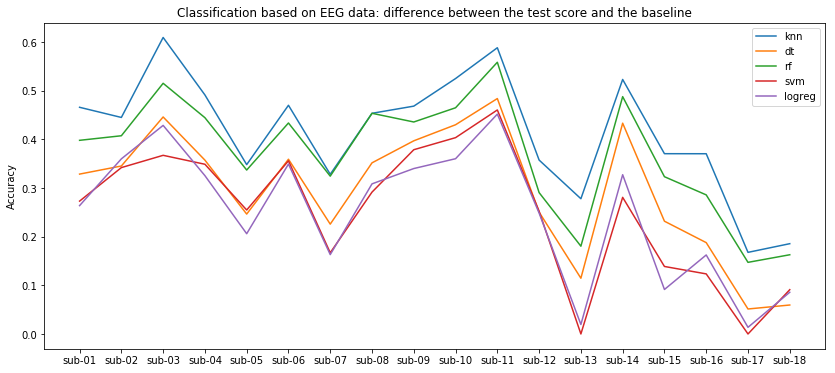

In [12]:
# Display the difference between the test score and the baseline for all subjects and all models. 
plt.figure(figsize = ((14, 6)))
for classification_model in ['knn', 'dt', 'rf', 'svm', 'logreg']:
    plt.plot(classification_based_on_EEG[classification_model] - classification_based_on_EEG_baselines[classification_model], label = classification_model)
plt.legend()
plt.ylabel('Accuracy')
plt.title('Classification based on EEG data: difference between the test score and the baseline');

**Result:** The best classification model seems to be the **k-NN** model, followed by the **random forest** model. There is a certain variability among the subjects, but overall, the classification models based on EEG data manage to predict the sleep stages of the hypnogram with an accuracy higher than the baseline. 

In [13]:
# Load the results from the classification based on fMRI data. 
with np.load(results_path + 'classification_with_fMRI_predictors.npz', allow_pickle = False) as npz_file:
    data_dict = dict(npz_file.items())

# Store the results as DataFrames. 
knn_results = pd.DataFrame(data_dict['knn_results'], index = subjects[1:], columns = ['knn__n_neighbors', 'test_score', 'baseline'])
dt_results = pd.DataFrame(data_dict['dt_results'], index = subjects[1:], columns = ['dt__max_depth', 'test_score', 'baseline'])
rf_results = pd.DataFrame(data_dict['rf_results'], index = subjects[1:], columns = ['rf__n_estimators', 'test_score', 'baseline'])
svm_results = pd.DataFrame(data_dict['svm_results'], index = subjects[1:], columns = ['svm__C', 'test_score', 'baseline'])
logreg_results = pd.DataFrame(data_dict['logreg_results'], index = subjects[1:], columns = ['logreg__C', 'test_score', 'baseline'])

In [14]:
# Create a Pandas DataFrame to hold all the test scores. 
classification_based_on_fMRI = pd.DataFrame()
for classification_model in ['knn', 'dt', 'rf', 'svm', 'logreg']:
    classification_based_on_fMRI[classification_model] = eval(classification_model + '_results')['test_score']

# Display the DataFrame. 
classification_based_on_fMRI

,knn,dt,rf,svm,logreg
sub-02,0.960720,0.932897,0.947627,0.954173,0.942717
sub-03,0.888462,0.719231,0.813462,0.857692,0.857692
sub-04,0.851064,0.789362,0.863830,0.889362,0.885106
sub-05,0.947075,0.864903,0.930362,0.948468,0.948468
sub-06,0.865894,0.817881,0.857616,0.879139,0.879139
sub-07,0.920304,0.798861,0.916509,0.924099,0.912713
sub-08,0.910494,0.848765,0.887346,0.888889,0.905864
sub-09,0.973523,0.942974,0.961303,0.993890,0.973523
sub-10,0.938547,0.835196,0.900838,0.928771,0.920391
sub-11,0.959488,0.848614,0.895522,0.929638,0.904051


In [15]:
# Create a Pandas DataFrame to hold all the baselines. 
classification_based_on_fMRI_baselines = pd.DataFrame()
for classification_model in ['knn', 'dt', 'rf', 'svm', 'logreg']:
    classification_based_on_fMRI_baselines[classification_model] = eval(classification_model + '_results')['baseline']

In [16]:
# Display the mean test score for the classification models. 
classification_based_on_fMRI.mean()

knn       0.904612
dt        0.817041
rf        0.873870
svm       0.889136
logreg    0.879937
dtype: float64

In [17]:
# Display the mean baseline for the classification models. 
classification_based_on_fMRI_baselines.mean()

knn       0.514066
dt        0.519998
rf        0.510799
svm       0.514931
logreg    0.511970
dtype: float64

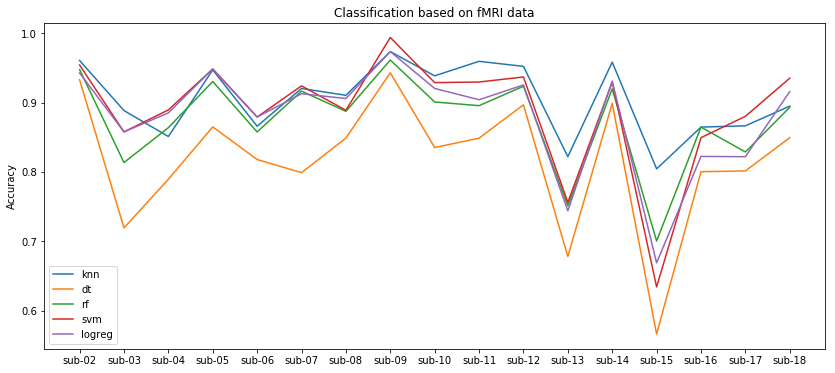

In [18]:
# Display the test score for all subjects and all models. 
plt.figure(figsize = ((14, 6)))
for classification_model in ['knn', 'dt', 'rf', 'svm', 'logreg']:
    plt.plot(classification_based_on_fMRI[classification_model], label = classification_model)
plt.legend()
plt.ylabel('Accuracy')
plt.title('Classification based on fMRI data');

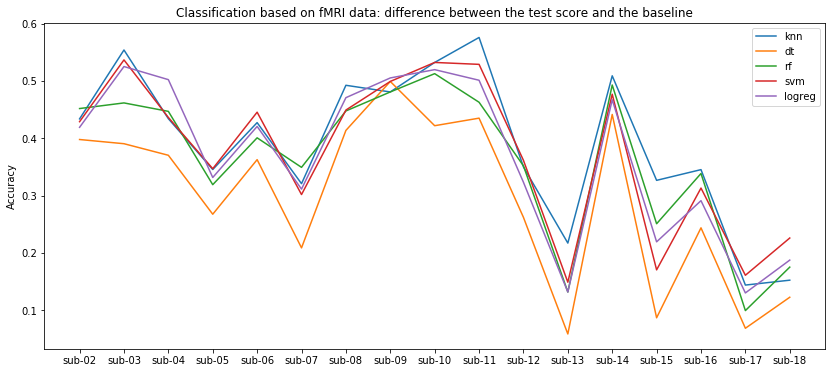

In [19]:
# Display the difference between the test score and the baseline for all subjects and all models. 
plt.figure(figsize = ((14, 6)))
for classification_model in ['knn', 'dt', 'rf', 'svm', 'logreg']:
    plt.plot(classification_based_on_fMRI[classification_model] - classification_based_on_fMRI_baselines[classification_model], label = classification_model)
plt.legend()
plt.ylabel('Accuracy')
plt.title('Classification based on fMRI data: difference between the test score and the baseline');

**Result:** Most classification models seem to have similar performances. There is a certain variability among the subjects, but overall, the classification models based on fMRI data manage to predict the sleep stages of the hypnogram with an accuracy higher than the baseline. 

## **3. Regression on fMRI data results**

### **3.1 Single subject**

In the following cells, we load the results from the **Notebook on Regression with fMRI predictors**, and compare the accuracy of the different regression models, for a single subject and the alpha frequency band. 

In [20]:
# Load the results from the regression based on fMRI data, for a single subject. 
with np.load(results_path + 'regression_with_fMRI_predictors_single_subject.npz', allow_pickle = False) as npz_file:
    data_dict = dict(npz_file.items())

# Example subject. 
subject_index = data_dict['subject_index']

# Baseline. 
rss_baseline = data_dict['rss_baseline']

# Linear regression. 
rss_lr = data_dict['rss_lr']
r2_lr = data_dict['r2_lr']
coef_lr = data_dict['coef_lr']
coefficients_image_lr = data_dict['coefficients_image_lr']

# Regression with Huber loss. 
rss_huber = data_dict['rss_huber']
r2_huber = data_dict['r2_huber']
coef_huber = data_dict['coef_huber']
coefficients_image_huber = data_dict['coefficients_image_huber']

# Ridge regression. 
rss_ridge = data_dict['rss_ridge']
r2_ridge = data_dict['r2_ridge']
coef_ridge = data_dict['coef_ridge']
coefficients_image_ridge = data_dict['coefficients_image_ridge']

# Lasso regression. 
rss_lasso = data_dict['rss_lasso']
r2_lasso = data_dict['r2_lasso']
coef_lasso = data_dict['coef_lasso']
coefficients_image_lasso = data_dict['coefficients_image_lasso']

In [21]:
# Display the example subject. 
subject_index

array('sub-02', dtype='<U6')

In [22]:
# Display the R^2 measure of the different regression models. 
r2_models = pd.DataFrame([r2_lr, r2_huber, r2_ridge, r2_lasso], columns = ['R^2 measure'], 
                          index = ['Linear regression', 'Regression with Huber loss', 'Ridge regression', 'Lasso regression'])
r2_models

,R^2 measure
Linear regression,0.702238
Regression with Huber loss,0.636238
Ridge regression,0.722143
Lasso regression,0.677392


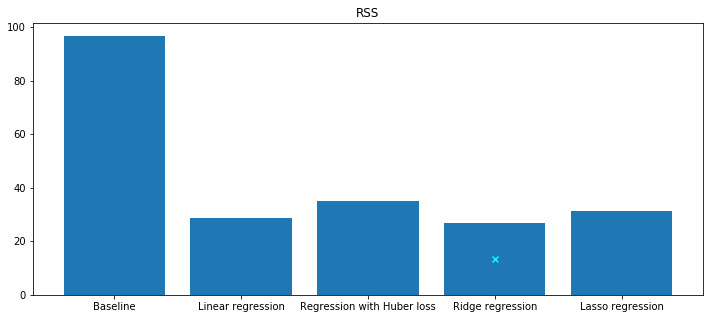

In [23]:
# Display the RSS measure of the different regression models. 
rss_models = pd.DataFrame([rss_baseline, rss_lr, rss_huber, rss_ridge, rss_lasso], columns = ['RSS measure'], 
                           index = ['Baseline', 'Linear regression', 'Regression with Huber loss', 'Ridge regression', 'Lasso regression'])
plt.figure(figsize = (12, 5))
plt.bar(rss_models.index, rss_models['RSS measure'])

# Point the best model on the graph according to the RSS measure. 
plt.scatter(rss_models.idxmin(), rss_models.min() / 2, marker = 'x', c = 'cyan', zorder = 10)
plt.title('RSS');

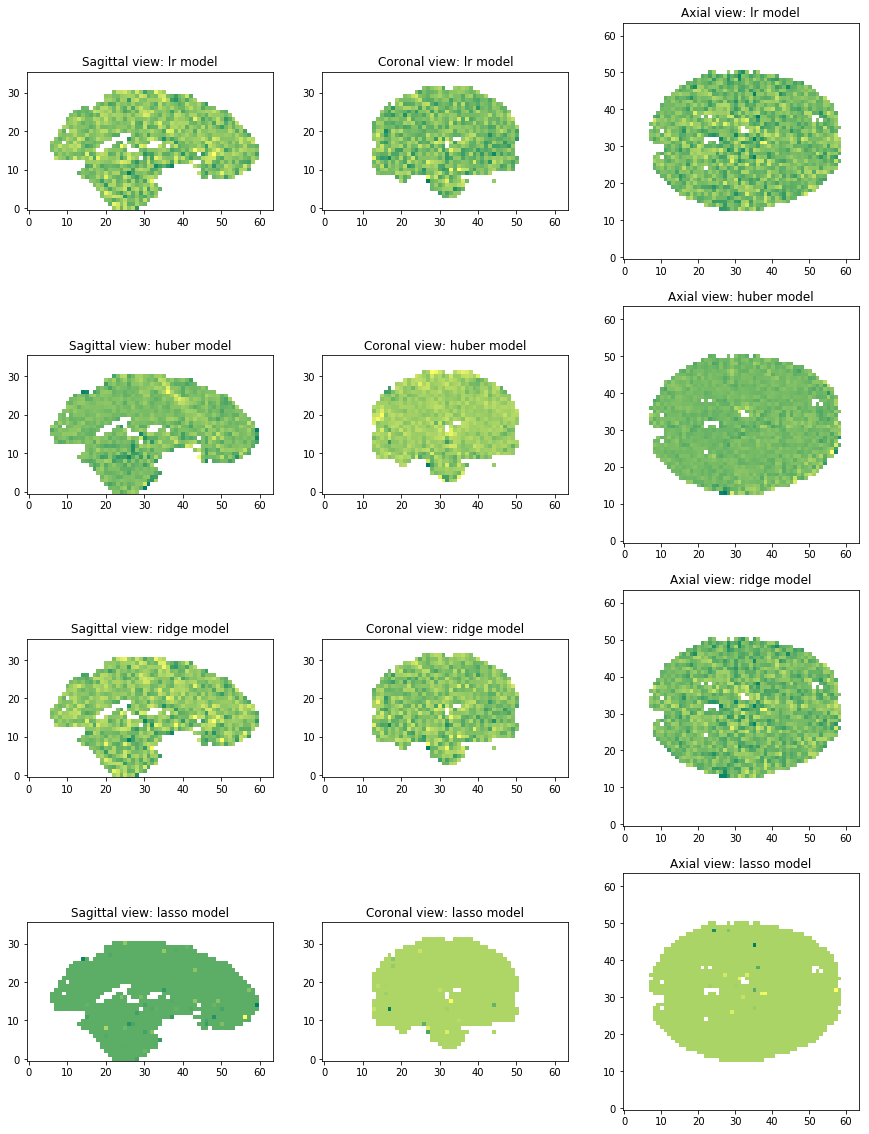

In [24]:
# Display the coefficient images for all the models. 
fig, axes = plt.subplots(nrows = 4, ncols = 3, figsize = (15, 20))
counter = 0

# Iterate through all the models. 
for regression_model in ['lr', 'huber', 'ridge', 'lasso']:
    
    # Retrieve the coefficient image and the middle section coordinates. 
    image_data = eval('coefficients_image_' + regression_model)
    middle_coord = middle_sections(image_data)
    
    axes[counter, 0].imshow(image_data[middle_coord[0], :, :].T, origin = 'lower', cmap = 'summer')
    axes[counter, 0].set_title('Sagittal view: ' + regression_model + ' model')
    axes[counter, 1].imshow(image_data[:, middle_coord[1], :].T, origin = 'lower', cmap = 'summer')
    axes[counter, 1].set_title('Coronal view: ' + regression_model + ' model')
    axes[counter, 2].imshow(image_data[:, :, middle_coord[2]], origin = 'lower', cmap = 'summer')
    axes[counter, 2].set_title('Axial view: ' + regression_model + ' model');
    
    # Increment. 
    counter += 1

**Result:** The regression models based on fMRI data manage to predict the selected EEG frequency band, here the alpha band, with an accuracy higher than the baseline. Most of the time, linear regression and Ridge regression produce similar results, while regression with Huber loss and Lasso regression show different patterns. 

### **3.2 All subjects**

In the following cells, we load again the results from the **Notebook on Regression with fMRI predictors**, and compare the accuracy of the linear regression model for all subjects and all EEG frequency bands. 

In [25]:
# Load the results from the regression based on fMRI data, for all subjects and all EEG frequency bands. 
with open(results_path + 'regression_with_fMRI_predictors.p', 'rb') as file:
    lr_results_at_subject_level = pickle.load(file)

In [26]:
# Define a function to plot the R^2 value for all subjects, for a certain target band. 
def plot_r2_for_all_subjects(target_band_index):
    color_names = ['purple', 'blue', 'green', 'gold', 'orange', 'red']
    r2_lr_all_subjects = []
    for subject_index in subjects[1:]: # Warning: the first subject has inconsistent length of EEG and fMRI data. 
        r2_lr_all_subjects.append(lr_results_at_subject_level[subject_index][target_band_index]['r2_lr'])
    plt.figure(figsize = (15, 8))
    plt.bar(range(2, 19), r2_lr_all_subjects, tick_label = subjects[1:], color = color_names[target_band_index - 2])
    plt.title(target_bands_names[target_band_index - 2]);

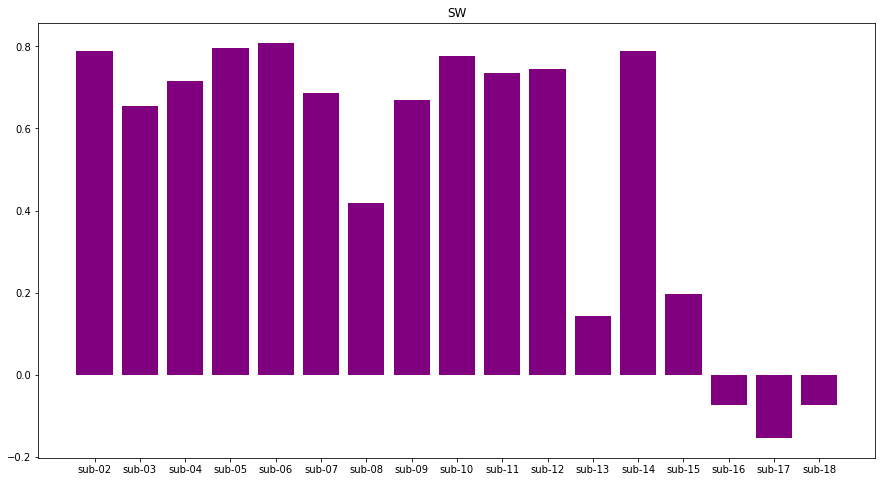

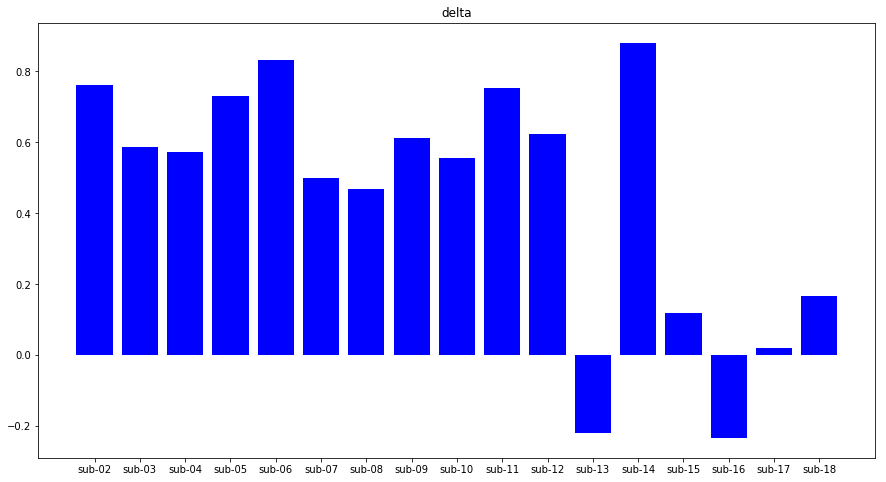

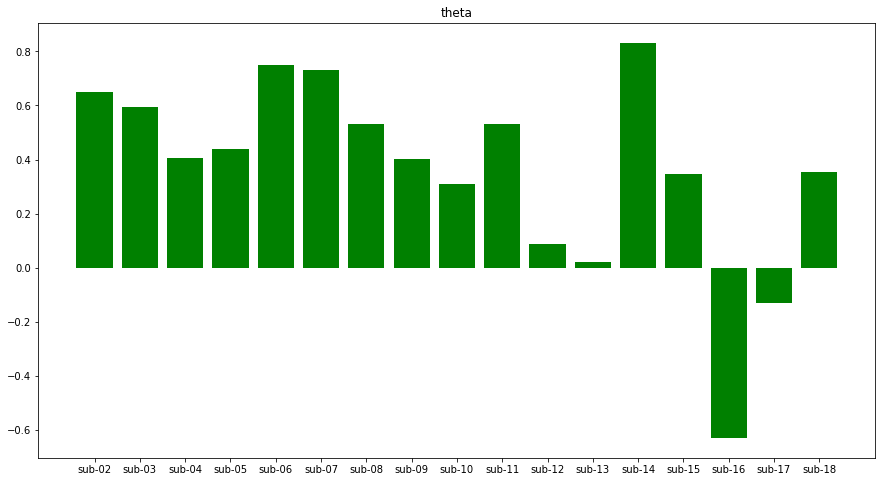

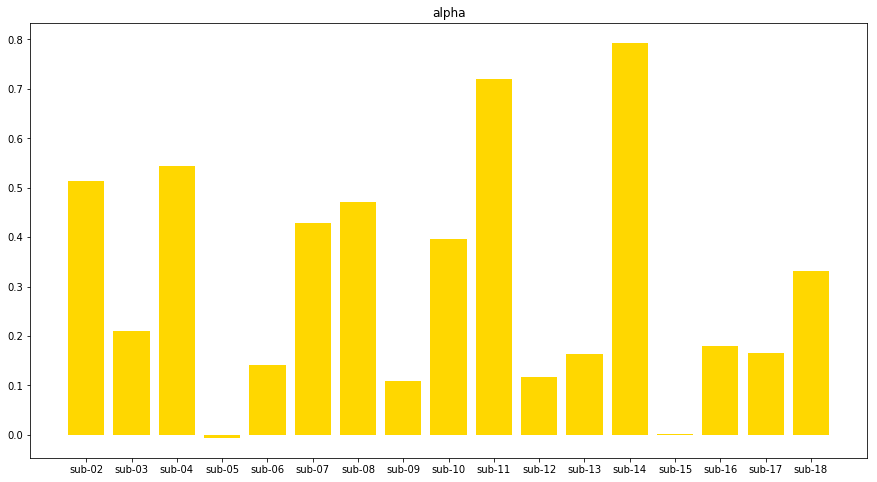

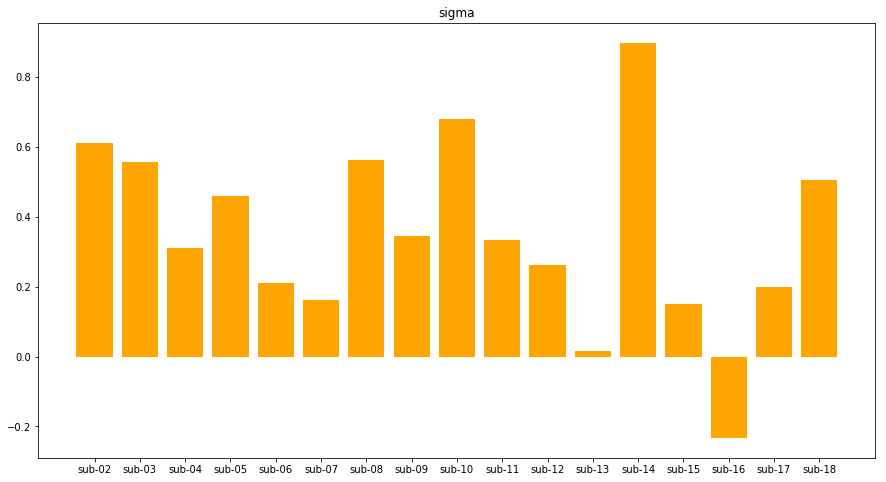

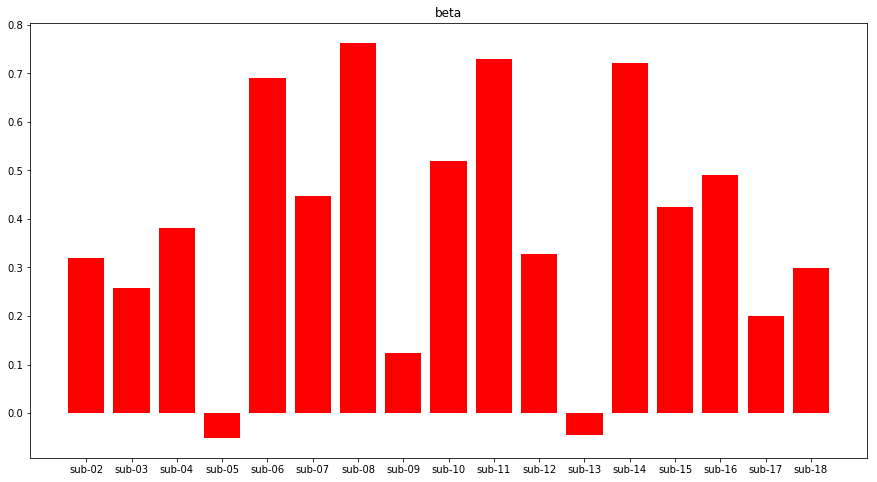

In [27]:
# Define the target bands names. 
target_bands_names = np.array(['SW', 'delta', 'theta', 'alpha', 'sigma', 'beta'])

# Plot the R^2 value for all subjects and all EEG frequency bands. 
for target_band_index in range(2, 8):
    plot_r2_for_all_subjects(target_band_index)

**Result:** As we already wrote in the corresponding Notebook, the linear regression performs better than the baseline for most of the subjects and the EEG frequency bands. Nevertheless, the R^2 measure is very variable, with a high predictability in some cases, and a low or even negative predictability in others. 

## **4. Regression on EEG data results**

### **4.1 Single subject**

In the following cells, we load the results from the **Notebook on Regression with EEG predictors**, and compare the accuracy of the different regression models, for a single subject and the peak voxel. 

In [28]:
# Load the results from the regression based on EEG data, for a single subject. 
with np.load(results_path + 'regression_with_EEG_predictors_single_subject.npz', allow_pickle = False) as npz_file:
    data_dict = dict(npz_file.items())

# Example subject. 
subject_index = data_dict['subject_index']

# Peak voxel. 
peak_voxel = data_dict['peak_voxel']
reconstructed_image = data_dict['reconstructed_image']

# Baseline. 
rss_baseline = data_dict['rss_baseline']

# Linear regression. 
rss_lr = data_dict['rss_lr']
r2_lr = data_dict['r2_lr']
coef_lr = data_dict['coef_lr']

# Regression with Huber loss. 
rss_huber = data_dict['rss_huber']
r2_huber = data_dict['r2_huber']
coef_huber = data_dict['coef_huber']

# Ridge regression. 
rss_ridge = data_dict['rss_ridge']
r2_ridge = data_dict['r2_ridge']
coef_ridge = data_dict['coef_ridge']

# Lasso regression. 
rss_lasso = data_dict['rss_lasso']
r2_lasso = data_dict['r2_lasso']
coef_lasso = data_dict['coef_lasso']

In [29]:
# Display the example subject. 
subject_index

array('sub-02', dtype='<U6')

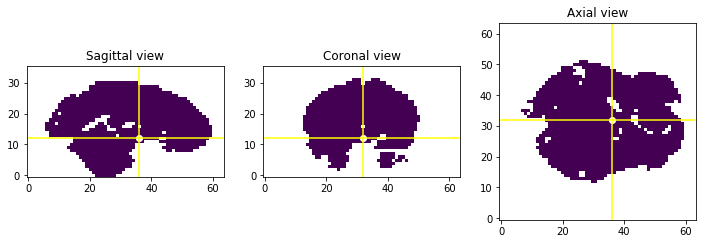

In [30]:
# Display the position of the peak voxel. 
display_voxel_or_cluster_position(peak_voxel, reconstructed_image, reconstructed_image.shape)

In [31]:
# Display the R^2 measure of the different regression models. 
r2_models = pd.DataFrame([r2_lr, r2_huber, r2_ridge, r2_lasso], columns = ['R^2 measure'], 
                          index = ['Linear regression', 'Regression with Huber loss', 'Ridge regression', 'Lasso regression'])
r2_models

,R^2 measure
Linear regression,0.035132
Regression with Huber loss,-0.003020
Ridge regression,0.037034
Lasso regression,0.042065


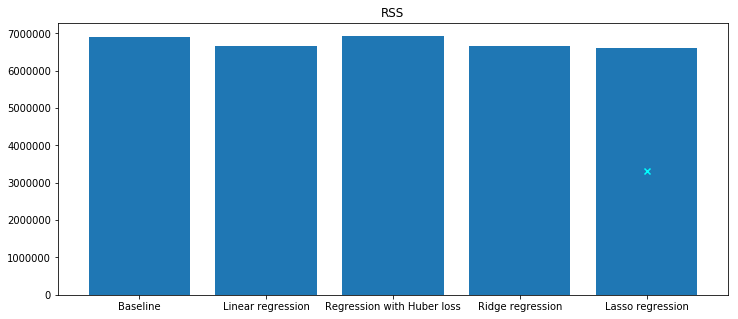

In [32]:
# Display the RSS measure of the different regression models. 
rss_models = pd.DataFrame([rss_baseline, rss_lr, rss_huber, rss_ridge, rss_lasso], columns = ['RSS measure'], 
                           index = ['Baseline', 'Linear regression', 'Regression with Huber loss', 'Ridge regression', 'Lasso regression'])
plt.figure(figsize = (12, 5))
plt.bar(rss_models.index, rss_models['RSS measure'])

# Point the best model on the graph according to the RSS measure. 
plt.scatter(rss_models.idxmin(), rss_models.min() / 2, marker = 'x', c = 'cyan', zorder = 10)
plt.title('RSS');

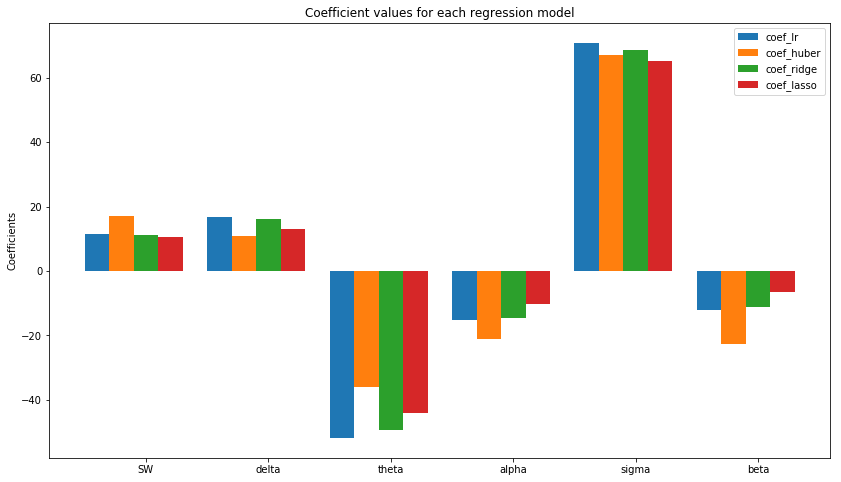

In [33]:
# Group all the coefficients in a dictionary. 
peak_voxel_results = dict({'coef_lr': coef_lr,
                           'coef_huber': coef_huber,
                           'coef_ridge': coef_ridge,
                           'coef_lasso': coef_lasso})

# Display the results in a graph. 
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (14, 8))
x_coord = np.array(range(0, 6))

# Iterate through all linear models. 
for linear_model in ['coef_lr', 'coef_huber', 'coef_ridge', 'coef_lasso']:
    axes.bar(x_coord, peak_voxel_results[linear_model], width = 0.2, label = linear_model)
    x_coord = x_coord + 0.2

# Add labels and title. 
axes.set_xticks(np.array(range(0, 6)) + 0.4)
axes.set_xticklabels(['SW', 'delta', 'theta', 'alpha', 'sigma', 'beta'])
axes.set_ylabel('Coefficients')
axes.legend()
axes.set_title('Coefficient values for each regression model');

**Result:** Most of the time, the regression models based on EEG data manage to predict the BOLD signal of the peak voxel with an accuracy slightly higher than the baseline. In the graph above, we can see that all regression models are very similar, except the regression with Huber loss which gives slightly different results. For the Ridge regression and the Lasso regression, the optimal regularization parameter is often very weak, and does not affect significatively the coefficients. 

### **4.2 All subjects**

In the following cells, we load again the results from the **Notebook on Regression with EEG predictors**, and compare the accuracy of the linear regression model for all subjects and all voxels. 

In [34]:
# Load the results from the regression based on EEG data, for all subjects and all voxels. 
with open(results_path + 'regression_with_EEG_predictors.p', 'rb') as file:
    lr_results_at_subject_level = pickle.load(file)

In [35]:
# Load the predictability maps. 
with open(results_path + 'regression_with_EEG_predictors_brain_maps.p', 'rb') as file:
    r2_brain_maps = pickle.load(file)

r2_images_per_subject = r2_brain_maps['r2_images_per_subject']
middle_coord_per_subject = r2_brain_maps['middle_coord_per_subject']

In [36]:
# Load the results from the regression based on EEG data, for all subjects and all voxels. 
with np.load(results_path + 'regression_with_EEG_predictors.npz', allow_pickle = False) as npz_file:
    data_dict = dict(npz_file.items())

# Results for all subjects and all voxels. 
lr_all_subjects_all_voxels_r2 = data_dict['lr_all_subjects_all_voxels_r2']
lr_all_subjects_all_voxels_sum_coef = data_dict['lr_all_subjects_all_voxels_sum_coef']

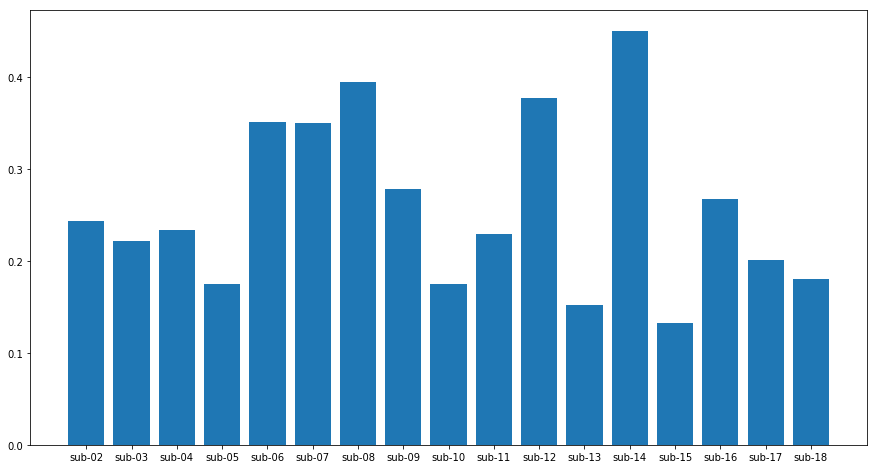

In [37]:
# Plot the mean R^2 measure for all subjects, averaging all voxels. 
plt.figure(figsize = (15, 8))
plt.bar(subjects[1:], lr_all_subjects_all_voxels_r2.mean(axis = 1));

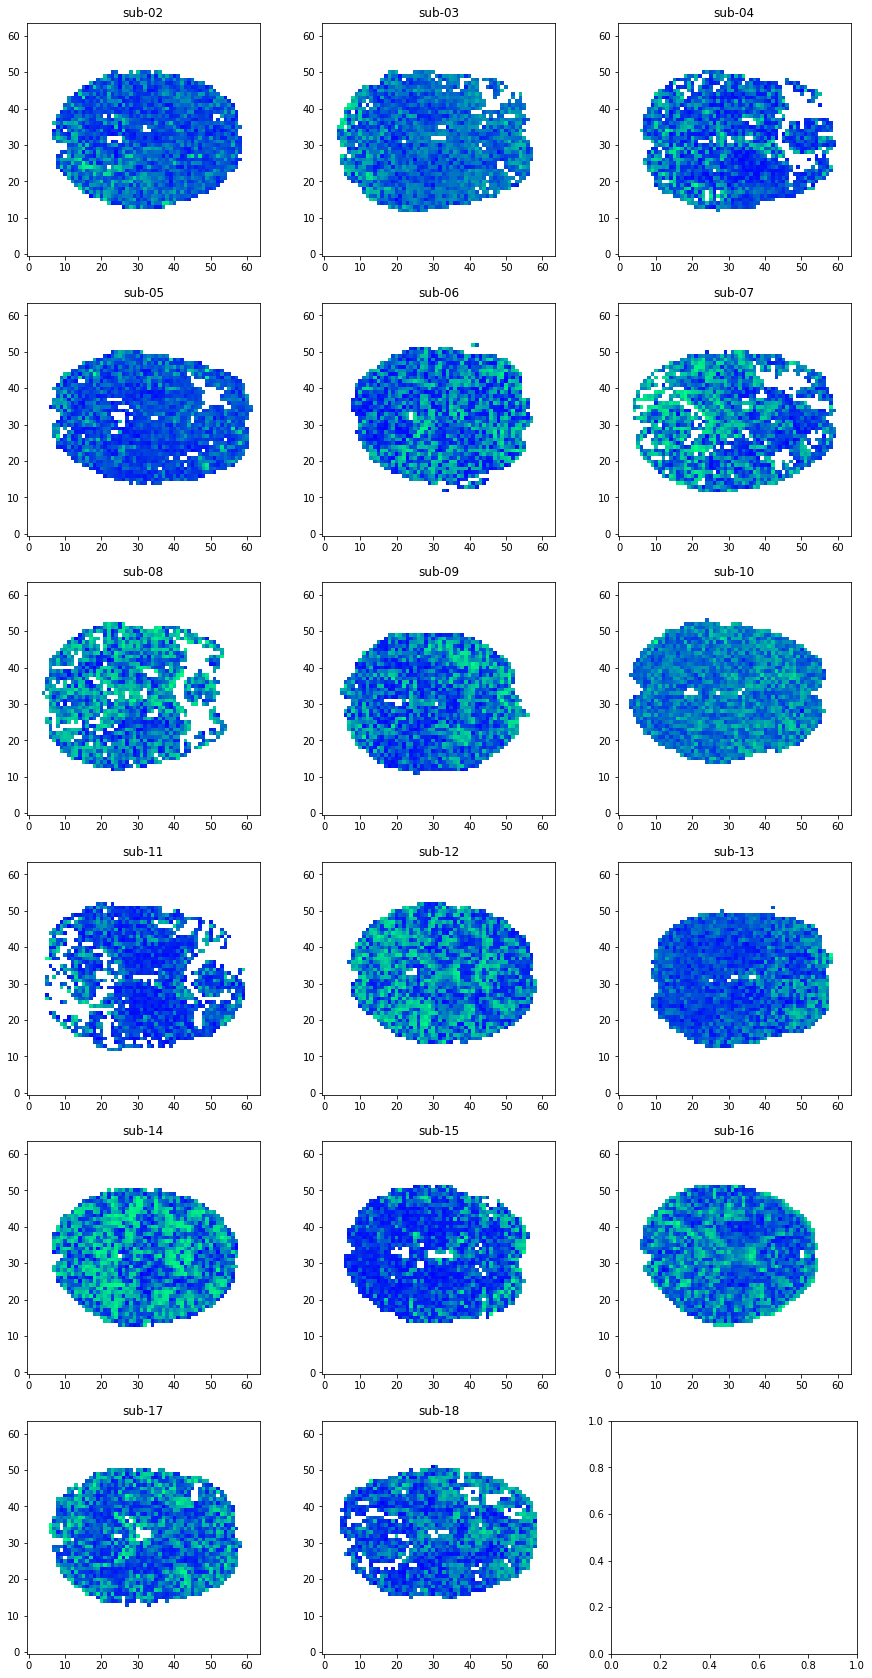

In [38]:
# Display the R^2 measure for each voxel at the middle section coordinates of the axial view. 
fig, axes = plt.subplots(nrows = 6, ncols = 3, figsize = (15, 30))
counter = 0

# Iterate through all subjects. 
for subject_index in subjects[1:]:
    
    # Compute the row and column indexes. 
    row_index = counter // 3
    column_index = counter % 3
    
    # Retrieve and display the R^2 image. 
    r2_image_lr = r2_images_per_subject[subject_index]
    middle_coord = middle_coord_per_subject[subject_index]
    axes[row_index, column_index].imshow(r2_image_lr[:, :, middle_coord[2]], origin = 'lower', cmap = 'winter')
    axes[row_index, column_index].set_title(subject_index);
    
    # Increment. 
    counter += 1

**Result:** As we already wrote in the corresponding Notebook, when averaging the R^2 measures of all the voxels, the linear regression performs better than the baseline for all the subjects. In the predictability maps, we can notice some clusters of voxels with similar R^2 measures. Since the brain images are not normalized into a common template, we cannot draw any conclusion regarding specific brain regions. Still, it appears that the BOLD signal from some regions may be relatively predictable by the EEG frequency bands, while in other regions, this signal remains more unpredictable. 

## **5. Discussion**

Overall, **classification models** predicted the hypnogram with an accuracy higher than the level of chance, whether they use EEG data or fMRI data as predictors. We expected such a result for the EEG data, since this type of data was certainly used for establishing the hypnogram in the first place, but we see now that fMRI data is also a good predictor of the sleep stages. 

Most of the time, **regression models based on fMRI data** predicted the EEG frequency bands with an accuracy higher than the level of chance. Nevertheless, they fail for some subjects and some frequency bands. It is interesting to notice that, while the dimensionality of the fMRI dataset is much higher than the dimensionality of the EEG dataset, the fMRI BOLD signal is still not sufficient to evaluate accurately the EEG frequency bands in all situations. Nevertheless, we can easily imagine all kinds of improvements in the machine learning pipeline. In particular, focusing on specific brain regions, for example the cortical regions which are directly responsible of the EEG signal, would seem like a sensible thing to try. 

For all subjects, **regression models based on EEG data** predicted on average the BOLD signal of the voxels with an accuracy higher than the level of chance. Nevertheless, the results are more contrasted if we look in detail at specific voxels. For example, while we obtained positive R^2 measures for the peak voxel of a single subject, the results were quite weak compared to the results obtained, also for a single subject, when we used the fMRI data as predictors of the alpha band. Still, it is very interesting to observe that EEG, a relatively cheap and easy to deploy technique, can to a certain extent predict an activity in the realm of fMRI, a much more sophisticated technique that requires an expensive machine and adequate facilities. 

This project also raises **multiple questions**. Can we apply machine learning models to all sorts of cross-modality neuroimaging datasets, or to datasets including both neurological and physiological measures? If we applied these techniques to brain maps normalized on a common template, could we make meaningful comparisons between subjects, and maybe transfer the model knowledge from one subject to another? In particular, would it be possible to train machine learning models on some EEG-fMRI dataset, and then use these models to predict EEG activity from fMRI activity, or vice versa, on another dataset of new and unseen subjects?

It is probable that **more opportunities for data analysis and machine learning will arise** when more and more researchers will store and share their data in open data repositories like OpenNeuro. Since there is a growing interest for EEG-fMRI research works, hopefully the cross-modality studies will also become more frequent, allowing machine learning models to be applied on a larger scale on this type of datasets. 

## **6. Conclusion**

This project demonstrated that it is possible to **train machine learning models to predict EEG activity from fMRI activity, and vice versa**. Regression models can be used to predict the value of EEG frequency bands or fMRI BOLD signal with an accuracy higher than the level of chance, while classification models can use both EEG and fMRI data to predict the hypnogram. Overall, the success of these models seems to prove that **machine learning can be used to extract subtle patterns from EEG and fMRI data**, which are on the other hand very difficult to recognize by visual inspection. 

As we mentioned in the introduction of the first Notebook, all neuroimaging techniques, whether they measure the electrical activity on the surface of the head or the changes in the cerebral blood flow, are ultimately grounded in the same neurophysiological reality. For a given EEG-fMRI dataset, proving that machine learning models can be trained to predict one modality based on the other, i.e. the EEG activity from fMRI activity or vice versa, suggests that **each technique provides some insight on processes that are, traditionally, in the realm of the other technique**. This project was conducted on a specific EEG-fMRI dataset, but the analyses developed in these Notebooks could likely be applied to other functional neuroimaging studies. Therefore, they might present an interest for the neuroimaging community, as well as for machine learning developers. 